In [22]:
import sys
print(sys.version)
print(sys.path)

3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]
['D:\\michele\\jennifer', 'D:\\michele\\miniconda3\\envs\\prediction\\python37.zip', 'D:\\michele\\miniconda3\\envs\\prediction\\DLLs', 'D:\\michele\\miniconda3\\envs\\prediction\\lib', 'D:\\michele\\miniconda3\\envs\\prediction', '', 'D:\\michele\\miniconda3\\envs\\prediction\\lib\\site-packages', 'D:\\michele\\miniconda3\\envs\\prediction\\lib\\site-packages\\xgboost-0.83.dev0-py3.7.egg', 'D:\\michele\\miniconda3\\envs\\prediction\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\mtinti\\.ipython']


In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msn
from scipy import stats
from scipy.spatial import distance
import re
from sklearn import cluster
from sklearn.metrics import  silhouette_score
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multitest as smm
from sklearn.decomposition import PCA
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
plt.style.use('ggplot')
from scipy.stats import ttest_ind
#from plotly.widgets import GraphWidget
from adjustText import adjust_text
import warnings
warnings.filterwarnings("ignore")

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
init_notebook_mode(connected=True)

In [24]:
path = 'D:/michele/jennifer/indata/Hippocampus/combined/txt/proteinGroups.txt'
df = pd.read_table(path)
df.head()
print(df.shape)
df = df[df['Only identified by site']!='+']
df = df[df['Potential contaminant']!='+']
df = df[df['Reverse']!='+']
print(df.shape)

(7397, 124)
(7084, 124)


In [25]:
hippo_cols = ['Reporter intensity corrected {} Hippocampus'.format(n) for n in range(1,11)]
hippo_df=df[hippo_cols]
hippo_df.head(10)

,Reporter intensity corrected 1 Hippocampus,Reporter intensity corrected 2 Hippocampus,Reporter intensity corrected 3 Hippocampus,Reporter intensity corrected 4 Hippocampus,Reporter intensity corrected 5 Hippocampus,Reporter intensity corrected 6 Hippocampus,Reporter intensity corrected 7 Hippocampus,Reporter intensity corrected 8 Hippocampus,Reporter intensity corrected 9 Hippocampus,Reporter intensity corrected 10 Hippocampus
152,37382.0,44103.0,43120.0,39512.0,43439.0,34445.0,32882.0,37165.0,37203.0,42526.0
153,1458800.0,1533800.0,1416400.0,1378000.0,1522300.0,1216900.0,1085100.0,1490200.0,1312600.0,615700.0
154,1276900.0,1345800.0,1226700.0,1125400.0,1316500.0,1008900.0,851180.0,1273000.0,1083300.0,595140.0
155,751950.0,790170.0,693740.0,671740.0,732560.0,575820.0,485000.0,751780.0,636580.0,388980.0
156,280690.0,279700.0,300880.0,335690.0,305910.0,253170.0,280620.0,288580.0,291180.0,240900.0
157,121100.0,127130.0,122370.0,117650.0,135190.0,107810.0,90850.0,119820.0,127840.0,73783.0
158,28097.0,26474.0,25467.0,33467.0,28754.0,24803.0,26648.0,25757.0,26264.0,19206.0
159,30260.0,28491.0,29799.0,27480.0,31239.0,27989.0,20987.0,33614.0,31501.0,16631.0
160,188140.0,174330.0,178330.0,198830.0,191110.0,172250.0,154890.0,178560.0,182320.0,179880.0
161,91349.0,94598.0,79415.0,81370.0,93421.0,73751.0,56409.0,91731.0,83483.0,45895.0


In [26]:
hippo_df = hippo_df.replace(0, np.nan)
hippo_df.dropna(how='all', axis=0,inplace=True)
#hippo_df.head(10)

In [27]:
hippo_df.columns = ['ND_1','ND_2','ND_3','HF_1','HF_2','HF_3','KO_1','KO_2','KO_3','null']
del hippo_df['null']
#hippo_df.head(10)

In [28]:
#np.log2(hippo_df).describe()

In [29]:
#np.log2(hippo_df).plot(kind='box')

In [30]:
#np.log2(hippo_df).plot(kind='kde')

In [31]:
col_sum = hippo_df.sum(axis=0)
target = np.mean(col_sum)
norm_facs = target / col_sum
norm_facs

ND_1    0.941219
ND_2    0.940059
ND_3    0.974797
HF_1    0.926877
HF_2    0.903445
HF_3    1.135692
KO_1    1.178270
KO_2    1.000952
KO_3    1.070785
dtype: float64

## Values Distributions

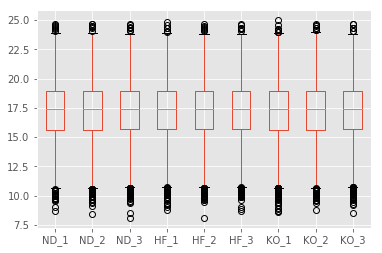

In [32]:
hippo_df = hippo_df.multiply(norm_facs,axis=1)
np.log2(hippo_df).plot(kind='box')

In [33]:
def make_pca(in_df):
    cols = in_df.columns
    pca = PCA(n_components=2)
    pca.fit(in_df)
    temp_df = pd.DataFrame()
    temp_df['pc_1']=pca.components_[0]
    temp_df['pc_2']=pca.components_[1]
    temp_df.index = cols
    print(pca.explained_variance_ratio_)
    fig,ax=plt.subplots()
    temp_df.iloc[0:3,:].plot(kind='scatter',x='pc_1',y='pc_2',s=50, c='g', ax=ax,legend ='ND')
    temp_df.iloc[3:6,:].plot(kind='scatter',x='pc_1',y='pc_2',s=50, c='b', ax=ax, legend='HF')    
    temp_df.iloc[6:9,:].plot(kind='scatter',x='pc_1',y='pc_2',s=50, c='r', ax=ax, legend='KO')
    for i, txt in enumerate(cols):
        ax.annotate(txt, (temp_df['pc_1'].values[i]+0.0003,temp_df['pc_2'].values[i]))
    #ax.set_xlabel('PC1({})'.format(round(pca.explained_variance_ratio_[0],2)))
    #ax.set_ylabel('PC2({})'.format(round(pca.explained_variance_ratio_[1],2)))
    #ax.set_xlim(0.345,0.360)
    ax.set_xlabel('PC1_{:.3f}'.format(pca.explained_variance_ratio_[0]))
    ax.set_ylabel('PC2_{:.3f}'.format(pca.explained_variance_ratio_[1]))
    
    ax.yaxis.label.set_size(12)
    ax.xaxis.label.set_size(12)
    #plt.tick_params(axis='both', which='major', labelsize=16, rotation=70, horizontalalignment='right' )
    #plt.setp( axs[1].xaxis.get_majorticklabels(), )
    fig.savefig('fig_Hippocampus/Hippocampus_pca.svg')
    fig.savefig('fig_Hippocampus/Hippocampus_pca.png')
    fig.savefig('fig_Hippocampus/Hippocampus_pca.pdf')
    plt.legend()
    plt.show()

## PCA plot

[0.99571157 0.0016948 ]


No handles with labels found to put in legend.


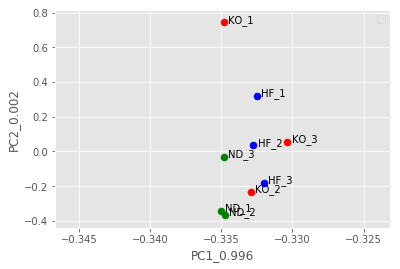

In [34]:
hippo_df=hippo_df.fillna(0)
make_pca(np.log1p(hippo_df))

In [35]:
onesample_results = ttest_ind(hippo_df[['ND_1','ND_2','ND_3']].T, 
                              hippo_df[['KO_1','KO_2','KO_3']].T)
#print(onesample_results)
hippo_df['ND_KO_pvalue']=onesample_results.pvalue
hippo_df['ND_KO_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]

onesample_results = ttest_ind(hippo_df[['HF_1','HF_2','HF_3']].T, 
                              hippo_df[['KO_1','KO_2','KO_3']].T)
#print(onesample_results)
hippo_df['HF_KO_pvalue']=onesample_results.pvalue
hippo_df['HF_KO_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]

onesample_results = ttest_ind(hippo_df[['HF_1','HF_2','HF_3']].T, 
                              hippo_df[['ND_1','ND_2','ND_3']].T)
#print(onesample_results)
hippo_df['HF_ND_pvalue']=onesample_results.pvalue
hippo_df['HF_ND_pvalue_corr']=multipletests(onesample_results.pvalue,method='bonferroni')[1]


hippo_df['log10_ND_KO_pvalue']=-np.log10(hippo_df['ND_KO_pvalue'])
hippo_df['log10_HF_KO_pvalue']=-np.log10(hippo_df['HF_KO_pvalue'])
hippo_df['log10_HF_ND_pvalue']=-np.log10(hippo_df['HF_ND_pvalue'])
hippo_df.head()

,ND_1,ND_2,ND_3,HF_1,HF_2,HF_3,KO_1,KO_2,KO_3,ND_KO_pvalue,ND_KO_pvalue_corr,HF_KO_pvalue,HF_KO_pvalue_corr,HF_ND_pvalue,HF_ND_pvalue_corr,log10_ND_KO_pvalue,log10_HF_KO_pvalue,log10_HF_ND_pvalue
152,3.518467e+04,4.145942e+04,4.203326e+04,3.662276e+04,3.924475e+04,3.911892e+04,3.874388e+04,3.720038e+04,3.983641e+04,0.698990,1.0,0.828659,1.0,0.628805,1.0,0.155529,0.081624,0.201484
153,1.373051e+06,1.441862e+06,1.380703e+06,1.277236e+06,1.375315e+06,1.382024e+06,1.278541e+06,1.491619e+06,1.405512e+06,0.924161,1.0,0.541459,1.0,0.253307,1.0,0.034252,0.266434,0.596353
154,1.201843e+06,1.265131e+06,1.195784e+06,1.043107e+06,1.189386e+06,1.145800e+06,1.002920e+06,1.274212e+06,1.159981e+06,0.409379,1.0,0.837855,1.0,0.123384,1.0,0.387874,0.076831,0.908740
155,7.077500e+05,7.428064e+05,6.762559e+05,6.226203e+05,6.618278e+05,6.539544e+05,5.714611e+05,7.524957e+05,6.816402e+05,0.510989,1.0,0.699653,1.0,0.050161,1.0,0.291588,0.155117,1.299635
156,2.641909e+05,2.629345e+05,2.932970e+05,3.111433e+05,2.763729e+05,2.875232e+05,3.306462e+05,2.888547e+05,3.117911e+05,0.077318,1.0,0.302187,1.0,0.270879,1.0,1.111722,0.519725,0.567224


In [36]:
#for visualization later
hippo_df['mean_ND'] = hippo_df[['ND_1','ND_2','ND_3']].median(axis=1)
hippo_df['mean_HF'] = hippo_df[['HF_1','HF_2','HF_3']].median(axis=1)
hippo_df['mean_KO'] = hippo_df[['KO_1','KO_2','KO_3']].median(axis=1)

hippo_df['log2_fc_HF_ND'] = np.log2(hippo_df['mean_HF']/hippo_df['mean_ND'])
hippo_df['log2_fc_ND_KO'] = np.log2(hippo_df['mean_ND']/hippo_df['mean_KO'])
hippo_df['log2_fc_HF_KO'] = np.log2(hippo_df['mean_HF']/hippo_df['mean_KO'])


## p-values distridibutions

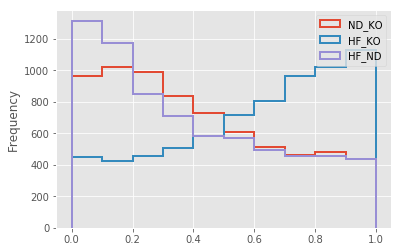

In [37]:
hippo_df['ND_KO_pvalue'].plot(kind='hist',bins=10,histtype='step',label='ND_KO',linewidth=2)
hippo_df['HF_KO_pvalue'].plot(kind='hist',bins=10,histtype='step',label='HF_KO',linewidth=2)
hippo_df['HF_ND_pvalue'].plot(kind='hist',bins=10,histtype='step',label='HF_ND',linewidth=2)
plt.legend()
plt.show()

bace_index 1363


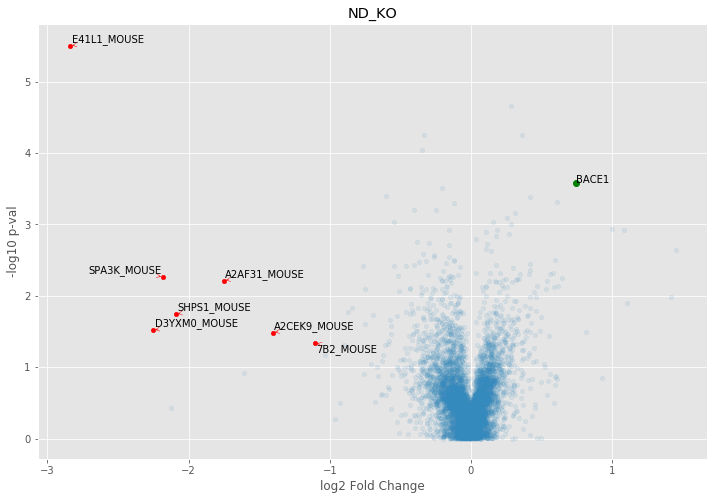

In [43]:
def find_sprot(index, series, sprot_id):
    for index,n in zip(index, series):
        if sprot_id in n:
            return index
    return -1


bace_index = find_sprot(df.index.values, df['Fasta headers'],'P56818')
print('bace_index', bace_index)
tag = 'ND_KO'

fig,ax=plt.subplots(figsize=(12,8))
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
        hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],marker='o', c='g')

plt.text(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
         hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0]) for i in select.index.values]


plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-val')
plt.title(tag)



adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
genes = df.loc[select.index.values]['Fasta headers']


fig.savefig('fig_Hippocampus/Hippocampus_ND_KO.svg')
fig.savefig('fig_Hippocampus/Hippocampus_ND_KO.png')
fig.savefig('fig_Hippocampus/Hippocampus_ND_KO.pdf')
genes

In [39]:

#interactive plot
trace_1 = go.Scatter(
    x=hippo_df['log2_fc_{}'.format(tag)],
    y=hippo_df['log10_{}_pvalue'.format(tag)],
    mode='markers',
    name='MA Plot',
    text = [df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0] for i in hippo_df.index.values],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = hippo_df['log10_{}_pvalue'.format(tag)], #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)


annot_1 = go.Scatter(
    x=[hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)]],
    y=[hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)]],
    mode='markers+text',
    name='BACE1',
    text=['BACE1'],
    textposition='bottom center'
)
layout = dict(title=tag,
             width=800,
             height=800,
              
             )

fig = go.Figure(data=[trace_1,annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [40]:
#significant after
#bonferroni correction
df.loc[hippo_df[hippo_df['ND_KO_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Phospho (STY) site IDs,Oxidation (M) site positions,Phospho (STY) site positions
6472,sp|Q9Z2H5|E41L1_MOUSE;tr|A0A2R8VHB6|A0A2R8VHB6...,sp|Q9Z2H5|E41L1_MOUSE,52;10,5;0,5;0,sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...,2,52,5,5,...,1088;1849;4453;8024;8778;9671;10662;12420;1249...,False;False;True;False;False;True;False;True;F...,1125;1929;4657;4658;8375;9164;9165;10091;10092...,2676;4314;4315;4316;4317;9980;9981;9982;9983;9...,2948;4715;4716;4717;4718;11122;11123;11124;111...,2948;4716;11125;19643;21283;23367;25906;29981;...,248;2834;2835;2836;2837;2838;2839;2840,1245;1246;1247;1248;1249;1250;1251;1252;1253;1...,264;282;389;580;734;739;767;854,378;430;461;466;475;489;648;650;652;677;685;78...


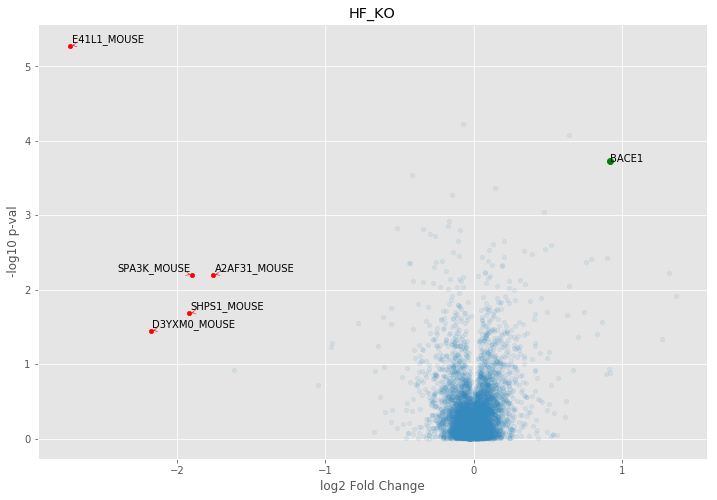

In [44]:
tag = 'HF_KO'

fig,ax=plt.subplots(figsize=(12,8))
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
        hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],marker='o', c='g')

plt.text(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
         hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0]) for i in select.index.values]


plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-val')
plt.title(tag)
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
genes = df.loc[select.index.values]['Fasta headers']


fig.savefig('fig_Hippocampus/Hippocampus_HF_KO.svg')
fig.savefig('fig_Hippocampus/Hippocampus_HF_KO.png')
fig.savefig('fig_Hippocampus/Hippocampus_HF_KO.pdf')
genes

In [42]:

#interactive plot
trace_1 = go.Scatter(
    x=hippo_df['log2_fc_{}'.format(tag)],
    y=hippo_df['log10_{}_pvalue'.format(tag)],
    mode='markers',
    name='MA Plot',
    text = [df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0] for i in hippo_df.index.values],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = hippo_df['log10_{}_pvalue'.format(tag)], #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)


annot_1 = go.Scatter(
    x=[hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)]],
    y=[hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)]],
    mode='markers+text',
    name='BACE1',
    text=['BACE1'],
    textposition='bottom center'
)

layout = dict(title=tag,
             width=800,
             height=800,
              
             )
             

fig = go.Figure(data=[trace_1,annot_1], 
                layout=layout)
iplot(fig, filename='test')

In [23]:
#significant
#bonferroni correction
df.loc[hippo_df[hippo_df['HF_KO_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Phospho (STY) site IDs,Oxidation (M) site positions,Phospho (STY) site positions
6472,sp|Q9Z2H5|E41L1_MOUSE;tr|A0A2R8VHB6|A0A2R8VHB6...,sp|Q9Z2H5|E41L1_MOUSE,52;10,5;0,5;0,sp|Q9Z2H5|E41L1_MOUSE Band 4.1-like protein 1 ...,2,52,5,5,...,1088;1849;4453;8024;8778;9671;10662;12420;1249...,False;False;True;False;False;True;False;True;F...,1125;1929;4657;4658;8375;9164;9165;10091;10092...,2676;4314;4315;4316;4317;9980;9981;9982;9983;9...,2948;4715;4716;4717;4718;11122;11123;11124;111...,2948;4716;11125;19643;21283;23367;25906;29981;...,248;2834;2835;2836;2837;2838;2839;2840,1245;1246;1247;1248;1249;1250;1251;1252;1253;1...,264;282;389;580;734;739;767;854,378;430;461;466;475;489;648;650;652;677;685;78...


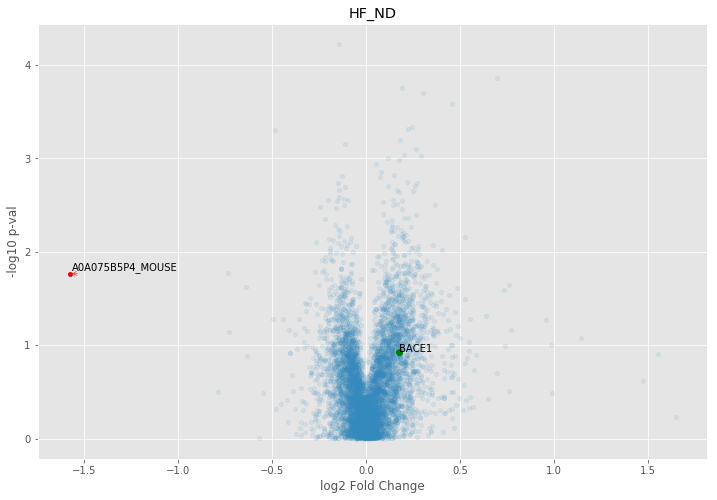

In [45]:
tag = 'HF_ND'

fig,ax=plt.subplots(figsize=(12,8))
hippo_df.plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, alpha=0.1)

hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)].plot(kind='scatter',
             x='log2_fc_{}'.format(tag),
             y='log10_{}_pvalue'.format(tag), 
             ax=ax, c='r')

select = hippo_df[(hippo_df['{}_pvalue'.format(tag)]<0.05) & 
         (hippo_df['log2_fc_{}'.format(tag)]<-1)]

ax.plot(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
        hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],marker='o', c='g')

plt.text(hippo_df.loc[bace_index]['log2_fc_{}'.format(tag)],
         hippo_df.loc[bace_index]['log10_{}_pvalue'.format(tag)],
        'BACE1')

texts = [plt.text(select.loc[i]['log2_fc_{}'.format(tag)], 
                  select.loc[i]['log10_{}_pvalue'.format(tag)], 
                  df.loc[i]['Fasta headers'].split('|')[2].split(';')[0].split(' ')[0]) for i in select.index.values]


plt.xlabel('log2 Fold Change')
plt.ylabel('-log10 p-val')
plt.title(tag)
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
genes = df.loc[select.index.values]['Fasta headers']


fig.savefig('fig_Hippocampus/Hippocampus_HF_ND.svg')
fig.savefig('fig_Hippocampus/Hippocampus_HF_ND.png')
fig.savefig('fig_Hippocampus/Hippocampus_HF_ND.pdf')
genes

In [46]:
#significant after
#bonferroni correction
df.loc[hippo_df[hippo_df['HF_ND_pvalue_corr']<0.05].index.values]

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Phospho (STY) site IDs,Oxidation (M) site positions,Phospho (STY) site positions


In [47]:
hippo_df.to_csv('Hippocampus.csv')

In [51]:
df = pd.read_table('D:/michele/jennifer/indata/Hippocampus/combined/txt/evidence.txt')
df.head()

,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Phospho (STY) Probabilities,Oxidation (M) Score Diffs,Phospho (STY) Score Diffs,Acetyl (Protein N-term),Oxidation (M),...,Potential contaminant,id,Protein group IDs,Peptide ID,Mod. peptide ID,MS/MS IDs,Best MS/MS,AIF MS/MS IDs,Oxidation (M) site IDs,Phospho (STY) site IDs
0,AAAAAAAAAAAAAAAGAAGK,20,Unmodified,_AAAAAAAAAAAAAAAGAAGK_,NaN,NaN,NaN,NaN,0,0,...,NaN,0,7061,0,0,0,0,NaN,NaN,NaN
1,AAAAAAAAAAAAAAAGAAGK,20,Unmodified,_AAAAAAAAAAAAAAAGAAGK_,NaN,NaN,NaN,NaN,0,0,...,NaN,1,7061,0,0,1,1,NaN,NaN,NaN
2,AAAAAAAAAAGAAGGR,16,Acetyl (Protein N-term),_(ac)AAAAAAAAAAGAAGGR_,NaN,NaN,NaN,NaN,1,0,...,NaN,2,3925,1,1,2,2,NaN,NaN,NaN
3,AAAAAAAAAAGAAGGR,16,Acetyl (Protein N-term),_(ac)AAAAAAAAAAGAAGGR_,NaN,NaN,NaN,NaN,1,0,...,NaN,3,3925,1,1,3,3,NaN,NaN,NaN
4,AAAAAAAAAAGDSDSWDADTFSMEDPVR,28,Acetyl (Protein N-term),_(ac)AAAAAAAAAAGDSDSWDADTFSMEDPVR_,NaN,NaN,NaN,NaN,1,0,...,NaN,4,2101,2,2,4,4,NaN,NaN,NaN


In [53]:
df = df[df['Reverse']!='+']
df = df[df['Potential contaminant']!='+']
#df['Fraction'].value_counts()
temp = df[['Sequence','Proteins']]
temp.drop_duplicates(subset=['Sequence'],inplace=True)
temp.set_index('Sequence',inplace=True)
pep_to_prot = temp.to_dict()

In [54]:
df['Raw file'].head()

0    PT8087-22
1    PT8087-22
2    PT8087-10
3    PT8087-11
4     PT8087-7
Name: Raw file, dtype: object

In [62]:
data=df[['Sequence', 'Experiment',
       'Reporter intensity corrected 1', 'Reporter intensity corrected 2',
       'Reporter intensity corrected 3', 'Reporter intensity corrected 4',
       'Reporter intensity corrected 5', 'Reporter intensity corrected 6',
       'Reporter intensity corrected 7', 'Reporter intensity corrected 8',
       'Reporter intensity corrected 9']]

In [63]:
res = data.groupby(['Sequence', 'Experiment']).sum().unstack()
res.columns = [n[0] + ' '+ n[1] for n in res.columns]
res.replace(0,np.nan,inplace=True)
#res.dropna(inplace=True)
res.head()

,Reporter intensity corrected 1 Hippocampus,Reporter intensity corrected 2 Hippocampus,Reporter intensity corrected 3 Hippocampus,Reporter intensity corrected 4 Hippocampus,Reporter intensity corrected 5 Hippocampus,Reporter intensity corrected 6 Hippocampus,Reporter intensity corrected 7 Hippocampus,Reporter intensity corrected 8 Hippocampus,Reporter intensity corrected 9 Hippocampus
Sequence,,,,,,,,,
AAAAAAAAAAAAAAAGAAGK,30798.0,31390.0,31873.0,31132.0,35085.0,22232.4,14211.0,19749.8,14905.9
AAAAAAAAAAGAAGGR,25380.0,25360.0,26319.0,28833.0,27959.0,23317.5,22028.4,24274.0,29044.0
AAAAAAAAAAGDSDSWDADTFSMEDPVR,4488.0,4324.5,3461.3,4628.8,5394.5,3718.2,3946.0,4092.5,3815.6
AAAAAAAAVGDPQPPQPEAPAQGLALDK,5747.2,5984.5,6235.6,5619.2,6197.7,4604.3,3346.7,5439.5,6320.1
AAAAAAAKMDGKESK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


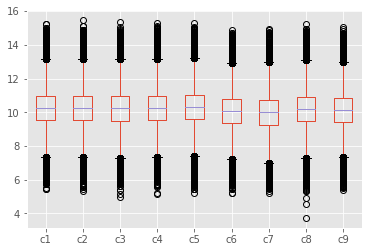

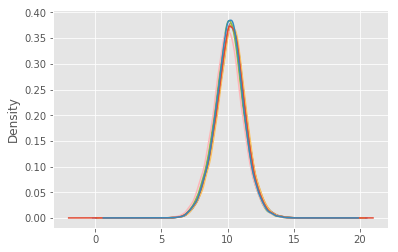

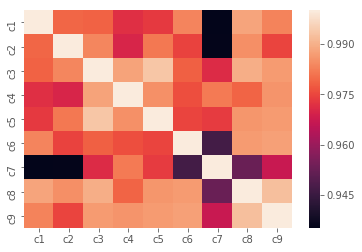

In [65]:
Hippo = res.copy()
#Hippo.dropna(inplace=True)
Hippo.columns = ['c'+str(n) for n in range(1,10)]
np.log1p(Hippo).plot(kind='box')
plt.show()
np.log1p(Hippo).plot(kind='kde',legend=False)
plt.show()
sns.heatmap(Hippo.corr())
plt.show()

In [66]:
temp = pd.DataFrame()
temp['exp1']=Hippo.sum(axis=0, skipna=True)
temp['target']=temp['exp1'].mean()
temp['n1'] = temp.target / temp.exp1
temp.head()

,exp1,target,n1
c1,3.976862e+09,3.745805e+09,0.941900
c2,3.980434e+09,3.745805e+09,0.941054
c3,3.842148e+09,3.745805e+09,0.974925
c4,4.044847e+09,3.745805e+09,0.926069
c5,4.147348e+09,3.745805e+09,0.903181


In [67]:
Hippo_sl = Hippo.multiply(temp['n1'].values)
Hippo_sl.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9
Sequence,,,,,,,,,
AAAAAAAAAAAAAAAGAAGK,29008.625025,29539.695775,31073.774416,28830.365520,31688.099610,25246.049511,16721.733400,19783.095663,15957.020578
AAAAAAAAAAGAAGGR,23905.412791,23865.138096,25659.042727,26701.333966,25252.032977,26478.237144,25920.275281,24314.922892,31092.098141
AAAAAAAAAAGDSDSWDADTFSMEDPVR,4227.245572,4069.589499,3374.506805,4286.586018,4872.209017,4222.209986,4643.160931,4099.399437,4084.664980
AAAAAAAAVGDPQPPQPEAPAQGLALDK,5413.285595,5631.739706,6079.240352,5203.764292,5597.643864,5228.422742,3937.979394,5448.670309,6765.775012
AAAAAAAKMDGKESK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


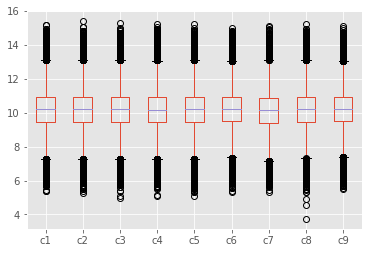

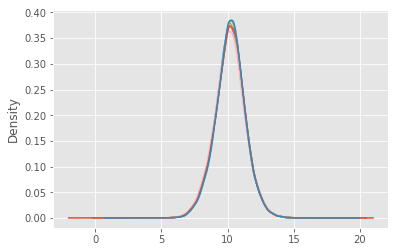

In [68]:
np.log1p(Hippo_sl).plot(kind='box')
plt.show()
np.log1p(Hippo_sl).plot(kind='kde',legend=False)
plt.show()

In [69]:
irs = Hippo_sl.sum(axis=1).to_frame()
irs.columns=['sum']
Hippo_sl = Hippo_sl.divide(irs['sum'].values, axis='index')
Hippo_sl.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9
Sequence,,,,,,,,,
AAAAAAAAAAAAAAAGAAGK,0.127315,0.129646,0.136379,0.126533,0.139075,0.110802,0.073390,0.086826,0.070033
AAAAAAAAAAGAAGGR,0.102515,0.102343,0.110036,0.114505,0.108290,0.113549,0.111156,0.104272,0.133335
AAAAAAAAAAGDSDSWDADTFSMEDPVR,0.111597,0.107435,0.089085,0.113164,0.128624,0.111464,0.122577,0.108222,0.107833
AAAAAAAAVGDPQPPQPEAPAQGLALDK,0.109788,0.114219,0.123295,0.105539,0.113527,0.106039,0.079867,0.110506,0.137219
AAAAAAAKMDGKESK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
Hippo_sl['prot']=[pep_to_prot['Proteins'][n] for n in Hippo_sl.index.values]
Hippo_sl.head()

,c1,c2,c3,c4,c5,c6,c7,c8,c9,prot
Sequence,,,,,,,,,,
AAAAAAAAAAAAAAAGAAGK,0.127315,0.129646,0.136379,0.126533,0.139075,0.110802,0.073390,0.086826,0.070033,tr|E9QM38|E9QM38_MOUSE;sp|P55012|S12A2_MOUSE
AAAAAAAAAAGAAGGR,0.102515,0.102343,0.110036,0.114505,0.108290,0.113549,0.111156,0.104272,0.133335,sp|Q8CCS6|PABP2_MOUSE;tr|G3UY42|G3UY42_MOUSE;t...
AAAAAAAAAAGDSDSWDADTFSMEDPVR,0.111597,0.107435,0.089085,0.113164,0.128624,0.111464,0.122577,0.108222,0.107833,sp|Q3UGC7|EI3JA_MOUSE
AAAAAAAAVGDPQPPQPEAPAQGLALDK,0.109788,0.114219,0.123295,0.105539,0.113527,0.106039,0.079867,0.110506,0.137219,sp|Q5U430|UBR3_MOUSE;tr|F6QC57|F6QC57_MOUSE
AAAAAAAKMDGKESK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sp|Q14AX6|CDK12_MOUSE


Text(0.5, 1.0, 'pep Q9Z2H5')

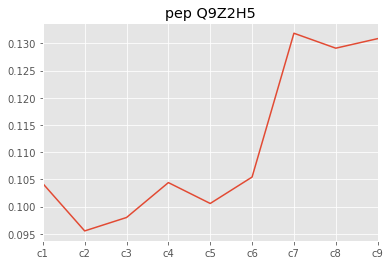

In [87]:
def find_prot(inlist, prot='Q3UGC7'):
    out = []
    for p,n in enumerate(inlist):
        if prot in n:
            out.append(p)
    return out

temp_index = find_prot(Hippo_sl['prot'].values, prot='Q9Z2H5')
Hippo_sl.iloc[temp_index].mean().plot()#kind='l',showfliers=False)
plt.title('pep Q9Z2H5')

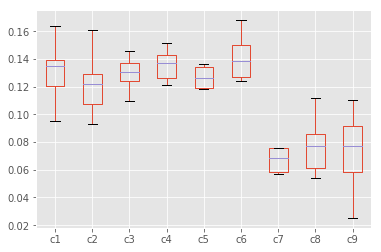

In [85]:
temp_index = find_prot(Hippo_sl['prot'].values, prot='P56818')
Hippo_sl.iloc[temp_index].plot(kind='box',showfliers=False)

In [86]:
Hippo_sl.to_csv('pep_norm_hippo.csv')